In [96]:
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm
from math import isclose
from scipy.optimize import fmin, minimize, root_scalar
import pickle
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from Ising_integrals import *
from routines import *
from known_formulas import *

## RS computation

In [101]:
p = 5
n_points_m = 1_000
n_points_T = 7
n_points_more_T = 3

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack(
    (
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
#Teqs = Teqs[27:]
es = -1 / (2 * Teqs)

In [102]:
#file_path = f'./data/rs_p{p:d}.pkl'
#if os.path.exists(file_path):
#    print("Data is already saved.")
#
#    with open(file_path, 'rb') as f:
#        tmp = pickle.load(f)
#        data = tmp['data']
#        ms = tmp['ms']
#
#    print("Data is loaded.")
#else:
#print("Data is not saved.")

ms = np.linspace(0., 0.999, n_points_m)
data = observables((len(Teqs), n_points_m))

for jdx, e in enumerate(tqdm(es, desc='RS')):
    for idx, m in enumerate(ms):
        h, q = fixed_points_h_q(m, e, p)

        data['q'][jdx, idx] = q
        data['h'][jdx, idx] = h
        data['T'][jdx, idx] = 1 / beta_q_e(q, m, e, p, h)
        data['delta_f'][jdx, idx] = deltaf_FP(m, q, h, p, e)
        data['s'][jdx, idx] = s_FP(m, q, h, p, e)
        data['dAT'][jdx, idx] = dAT_condition(
            q, m, h, beta_q_e(q, m, e, p, h), -e, p
        )
        data['m_check'][jdx, idx] = compute_m_FP(m, q, h, p, e)
        data
        


#with open(f'./data/rs_p{p:d}.pkl', 'wb') as f:
#    pickle.dump({'data': data, 'ms': ms}, f)
#
#print("Data is saved.")


RS:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/ghio/Desktop/fixed-energy-slice/Ising_integrals.py:193: RuntimeWarning: overflow encountered in cosh
  ** (-4)


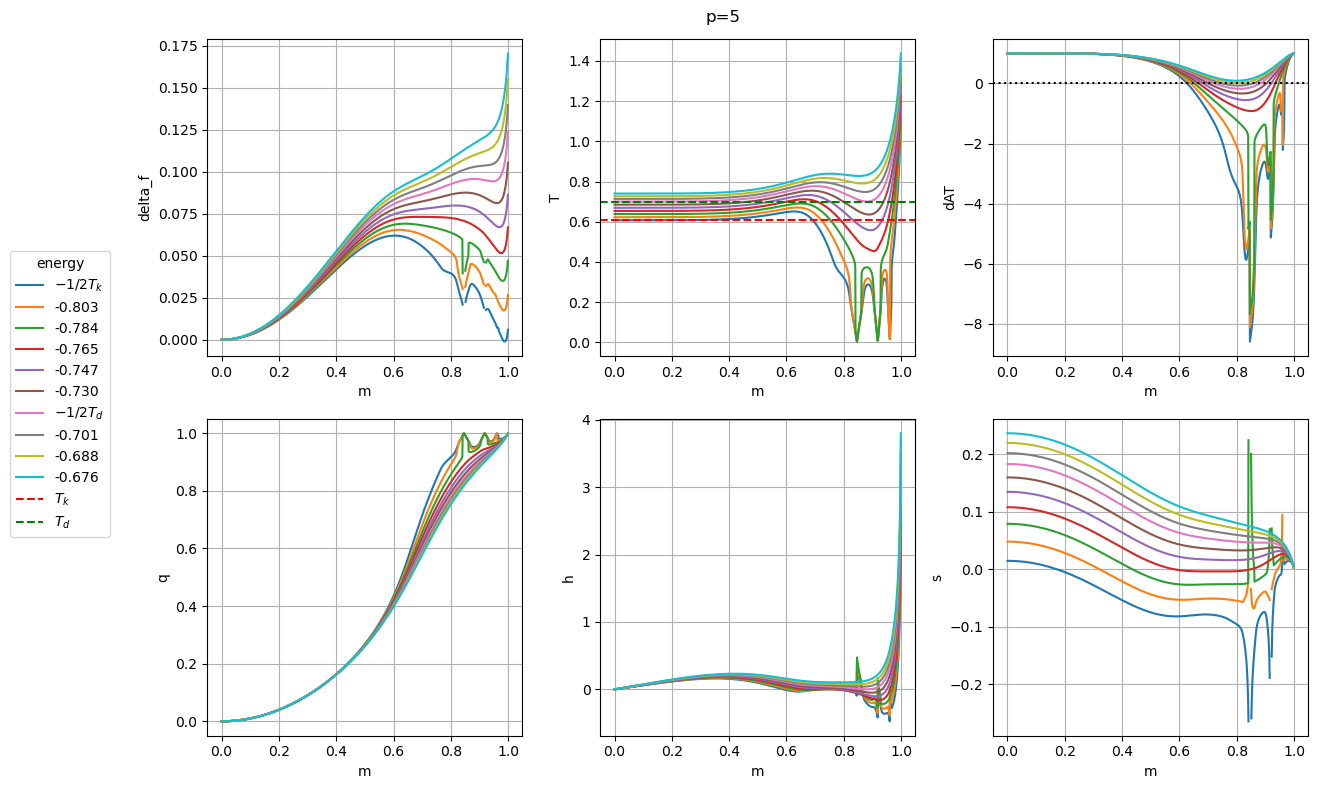

In [103]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle(f'p={p}')

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    for idx, (key, item) in enumerate(data.items()):
        if key == 'q':
            axs[idx // 3 , idx % 3].plot(ms, item[jdx,:], '-', label=legend_name)
            axs[idx // 3 , idx % 3].set_ylabel("q")
        else:
            axs[idx // 3 , idx % 3].plot(ms, item[jdx,:], '-', label=legend_name)
            axs[idx // 3 , idx % 3].set_ylabel(key)

        axs[idx // 3 , idx % 3].set_xlabel('m')
        axs[idx // 3 , idx % 3].grid(True)

position_T = list(data.keys()).index('T')
axs[position_T // 3 , position_T % 3].axhline(y=T_kauz, color='r', linestyle='--', label=r'$T_k$')
axs[position_T // 3 , position_T % 3].axhline(y=T_dyn, color='g', linestyle='--', label=r'$T_d$')

position_dAT = list(data.keys()).index('dAT')
axs[position_dAT // 3 , position_dAT % 3].axhline(y=0, color='k', linestyle=':', label=r'$\Delta A = 0$')

handles, labels = [], []
# for ax in axs.flat:
ax = axs[0,1]
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
#plt.savefig(f'./imgs/FPpspin_p{p}.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=360)

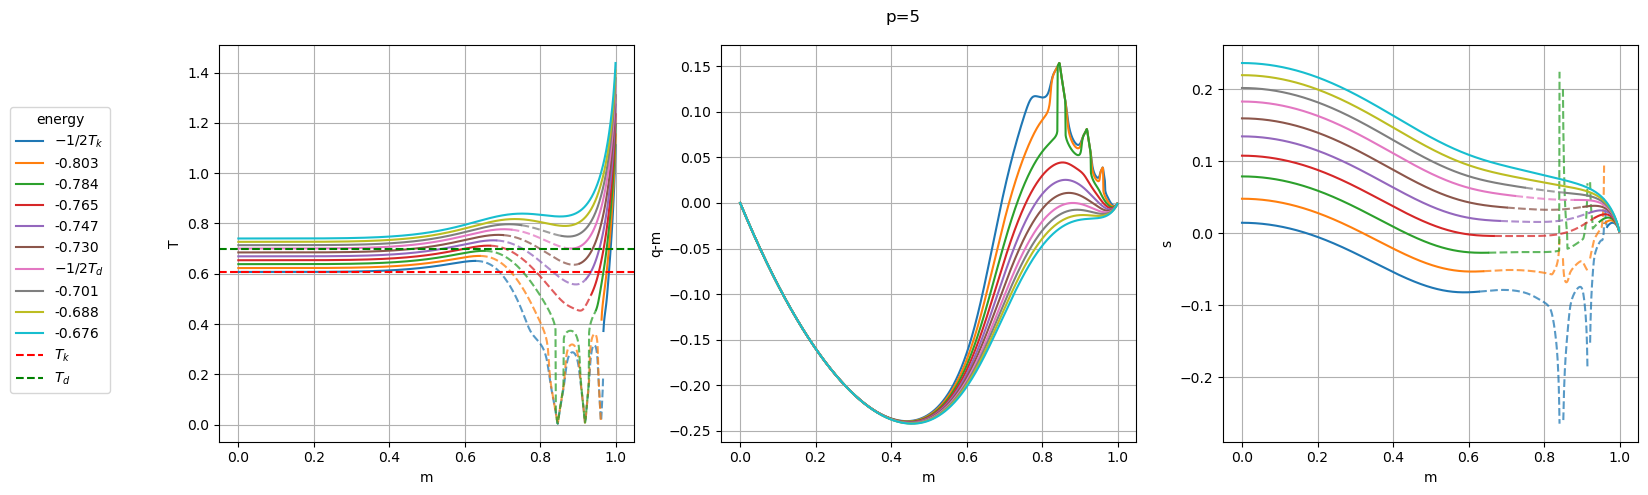

In [104]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"p={p}")

data_filtered = {
    key: value for key, value in data.items() if key in ["q", "T", "s"]
}

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    for idx, (key, item) in enumerate(data_filtered.items()):
        if key == 'q':
            axs[idx].plot(ms, item[jdx,:]-ms, '-', label=legend_name)
            axs[idx].set_ylabel("q-m")
        else:
            plot_dashed_instable(axs[idx], ms, item[jdx], stable_idxs, color, legend_name)
            axs[idx].set_ylabel(key)
        axs[idx].set_xlabel("m")
        axs[idx].grid(True)

position_T = list(data_filtered.keys()).index("T")
axs[position_T].axhline(y=T_kauz, color="r", linestyle="--", label=r"$T_k$")
axs[position_T].axhline(y=T_dyn, color="g", linestyle="--", label=r"$T_d$")

handles, labels = [], []
ax = axs[position_T]
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
#plt.savefig(
#    f"./imgs/FPpspin_p{p}_small.png",
#    bbox_extra_artists=(lgd,),
#    bbox_inches="tight",
#    dpi=360,
#)

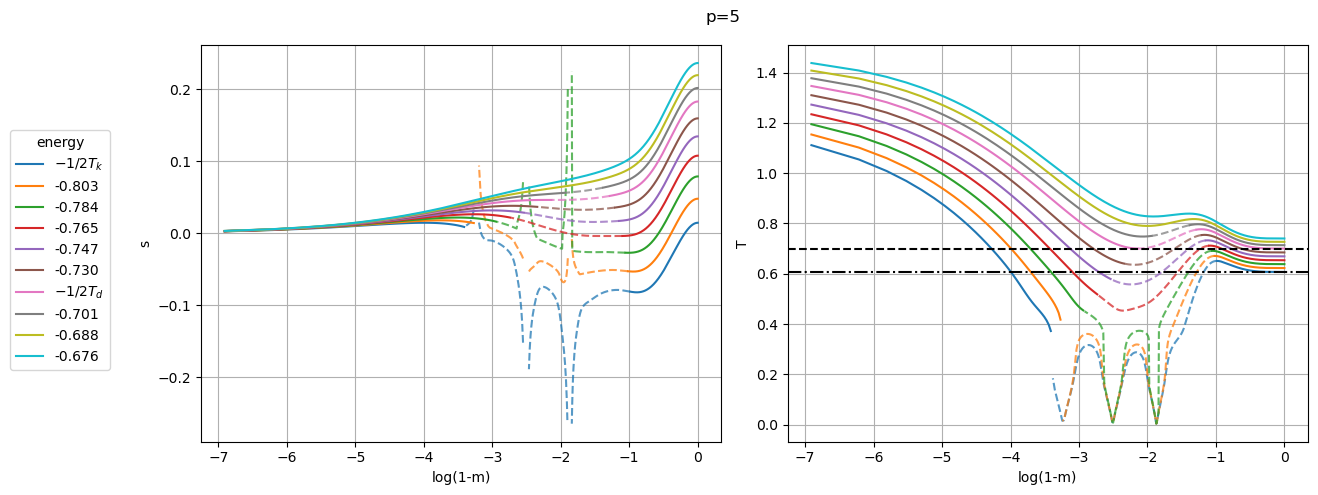

In [106]:
#plot s vs log(1-m) 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"p={p}")

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    plot_dashed_instable(ax[0], np.log(1-ms), data["s"][jdx], stable_idxs, color, legend_name)
    plot_dashed_instable(ax[1], np.log(1-ms), data["T"][jdx], stable_idxs, color, legend_name)
    #ax[0].plot(np.log(1-ms), data["s"][jdx], label=legend_name)
    #ax[1].plot(np.log(1-ms), data["T"][jdx], label=legend_name)

ax[0].set_ylabel("s")
ax[0].set_xlabel("log(1-m)")
ax[0].grid(True)

ax[1].set_ylabel("T")
ax[1].set_xlabel("log(1-m)")
ax[1].grid(True)
handles, labels = [], []
for handle, label in zip(*ax[1].get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)
position_T = list(data_filtered.keys()).index("T")
ax[1].axhline(y=T_kauz, color="k", linestyle="-.", label=r"$T_k$")
ax[1].axhline(y=T_dyn, color="k", linestyle="--", label=r"$T_d$")

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
plt.savefig(f'./imgs/FPpspin_log1mm_p{p}.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=360)
